# 1. loading datasets

Training has to be done with dropout as data is not always present

In [36]:
import torch
import pandas as pd
import numpy as np
import time
import joblib
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F




In [ ]:

from torch import nn 

# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get current CUDA device index (if available)
if torch.cuda.is_available():
    print("Current CUDA device index:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA devices found.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


PyTorch version: 2.4.1+cpu
CUDA available: False
No CUDA devices found.


In [ ]:
# Update with the correct path
# file_path = './Data/12_Sep_Readings/combined_data.csv'  
# file_path = './Data/15_Nov_Readings/augmented_rssi_dataset.csv'
file_path = './Data/25-02-10/cleaned_df.csv'
model_path = './models/CNN'
cleaned_df = pd.read_csv(file_path)

In [39]:
cleaned_df

,Tx_0 RSSI,Tx_0 Batt,Tx_0 Time,Tx_1 RSSI,Tx_1 Batt,Tx_1 Time,Tx_2 RSSI,Tx_2 Batt,Tx_2 Time,Tx_3 RSSI,...,Tx_5 Batt,Tx_5 Time,Tx_6 RSSI,Tx_6 Batt,Tx_6 Time,Tx_7 RSSI,Tx_7 Batt,Tx_7 Time,X_Coord,Y_Coord
0,-58,4.16,0.0,-65,4.13,0.0,-72,4.13,0.0,127,...,4.09,0.0,-81,4.12,0.0,-73,4.10,0.0,0,0
1,-59,4.11,21.0,-67,4.15,21.0,-72,4.11,20.0,-77,...,4.07,17.0,-80,4.12,15.0,-75,NaN,17.0,0,0
2,-59,4.14,38.0,-67,4.14,38.0,-73,NaN,40.0,-77,...,4.08,40.0,-79,4.13,38.0,-76,4.11,35.0,0,0
3,-60,4.16,57.0,-68,4.13,57.0,-73,4.12,56.0,-70,...,4.07,54.0,-83,4.13,50.0,-76,NaN,51.0,0,0
4,-60,4.16,74.0,-68,4.13,74.0,-73,4.11,72.0,-70,...,NaN,79.0,-81,4.14,78.0,-76,NaN,79.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-74,NaN,357.0,-66,NaN,358.0,-67,4.07,357.0,-54,...,4.00,357.0,-76,4.11,352.0,-77,4.06,347.0,5,6
1275,-73,4.11,373.0,-67,4.10,368.0,-67,4.08,368.0,-54,...,4.00,376.0,-75,4.10,373.0,-77,4.07,367.0,5,6
1276,-73,4.11,394.0,-67,NaN,394.0,-68,NaN,398.0,-54,...,4.01,402.0,-75,4.11,397.0,-78,4.06,392.0,5,6
1277,-73,4.02,419.0,-67,4.11,415.0,-68,4.08,415.0,-53,...,4.01,419.0,-74,4.11,415.0,-78,4.06,409.0,5,6


In [40]:

batt_columns = [col for col in cleaned_df.columns if 'Batt' in col]
time_columns = [col for col in cleaned_df.columns if 'Time' in col]
columns_to_drop = batt_columns+time_columns
RSSI_columns = cleaned_df.drop(columns=columns_to_drop)







cleaned_df.shape

(1279, 26)

In [41]:
# cleaned_df
RSSI_columns

,Tx_0 RSSI,Tx_1 RSSI,Tx_2 RSSI,Tx_3 RSSI,Tx_4 RSSI,Tx_5 RSSI,Tx_6 RSSI,Tx_7 RSSI,X_Coord,Y_Coord
0,-58,-65,-72,127,-74,-75,-81,-73,0,0
1,-59,-67,-72,-77,-72,-76,-80,-75,0,0
2,-59,-67,-73,-77,-70,-81,-79,-76,0,0
3,-60,-68,-73,-70,-72,-81,-83,-76,0,0
4,-60,-68,-73,-70,-71,-82,-81,-76,0,0
...,...,...,...,...,...,...,...,...,...,...
1274,-74,-66,-67,-54,-69,-66,-76,-77,5,6
1275,-73,-67,-67,-54,-69,-66,-75,-77,5,6
1276,-73,-67,-68,-54,-70,-65,-75,-78,5,6
1277,-73,-67,-68,-53,-70,-66,-74,-78,5,6


In [42]:
from common_utils import preprocess_dataset

# X = cleaned_df[['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']]
# X = cleaned_df[['Tx_0 RSSI_Avg', 'Tx_1 RSSI_Avg', 'Tx_2 RSSI_Avg', 'Tx_3 RSSI_Avg', 'Tx_4 RSSI_Avg', 'Tx_5 RSSI_Avg', 'Tx_6 RSSI_Avg', 'Tx_7 RSSI_Avg']]
rssi_columns = ['Tx_0 RSSI', 'Tx_1 RSSI', 'Tx_2 RSSI', 'Tx_3 RSSI', 'Tx_4 RSSI', 'Tx_5 RSSI', 'Tx_6 RSSI', 'Tx_7 RSSI']


# Replace 127 with 0 in the RSSI columns
cleaned_df[rssi_columns] = cleaned_df[rssi_columns].replace(127, 0)

scaler = MinMaxScaler()
cleaned_df[rssi_columns] = scaler.fit_transform(cleaned_df[rssi_columns])

X = cleaned_df[rssi_columns]
Y = cleaned_df[['X_Coord', 'Y_Coord']]



In [43]:
location_groups = cleaned_df.groupby(['X_Coord', 'Y_Coord'])
cnn_input_data = []
cnn_labels = []

for location, group in location_groups:
    rssi_values = group[rssi_columns].values
    for sample in rssi_values:
        heatmap = np.zeros((3, 3))
        heatmap[0, :] = sample[:3]
        heatmap[1, 0] = sample[3]
        heatmap[1, 2] = sample[4]
        heatmap[2, :] = sample[5:]
        cnn_input_data.append(heatmap)
        cnn_labels.append(location)

cnn_input_data = np.array(cnn_input_data)
cnn_labels = np.array(cnn_labels)

print(f"Input data shape for CNN: {cnn_input_data.shape}")
print(f"Labels shape: {cnn_labels.shape}")

Input data shape for CNN: (1279, 3, 3)
Labels shape: (1279, 2)


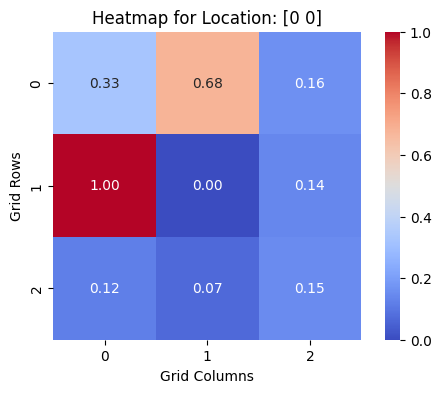

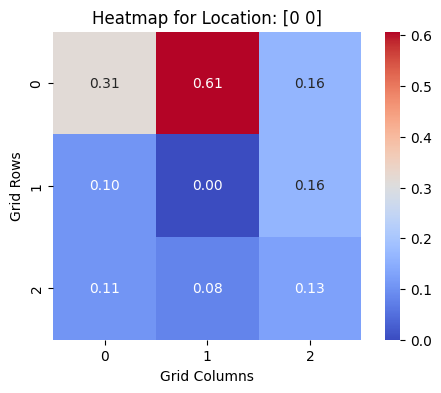

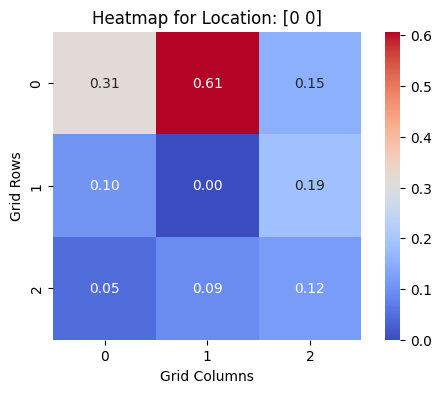

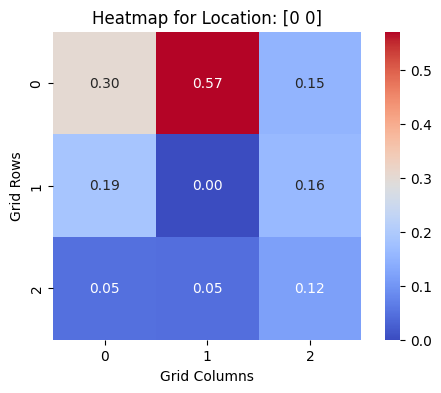

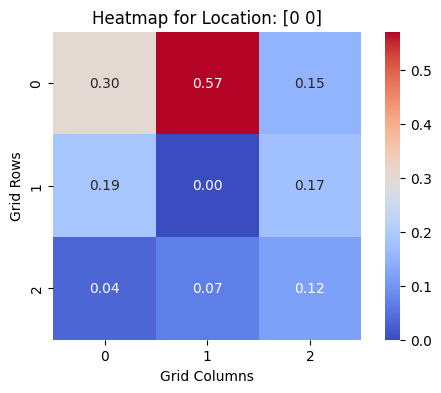

In [44]:
for idx, (heatmap, label) in enumerate(zip(cnn_input_data, cnn_labels)):
    plt.figure(figsize=(6, 4))
    sns.heatmap(heatmap, cmap='coolwarm', annot=True, cbar=True, square=True, fmt=".2f")
    plt.title(f"Heatmap for Location: {label}")
    plt.xlabel("Grid Columns")
    plt.ylabel("Grid Rows")
    plt.show()
    if idx == 4:
        break


In [45]:
cnn_input_data = torch.tensor(cnn_input_data, dtype=torch.float32).unsqueeze(1)
cnn_labels = torch.tensor(cnn_labels, dtype=torch.float32)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(cnn_input_data, cnn_labels, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: torch.Size([1023, 1, 3, 3])
y_train shape: torch.Size([1023, 2])


# 2. NN model

In [46]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # No pooling here
        x = F.relu(self.conv2(x))  # No pooling here
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [47]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [49]:
# Training loop
num_epochs = 200
patience = 40
best_val_loss = float('inf')
epochs_without_improvement = 0

In [50]:

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch [10/200], Train Loss: 10.2467, Val Loss: 8.9317
Epoch [20/200], Train Loss: 6.9483, Val Loss: 6.3740
Epoch [30/200], Train Loss: 5.9511, Val Loss: 5.9115
Epoch [40/200], Train Loss: 5.4566, Val Loss: 5.4580
Epoch [50/200], Train Loss: 5.2864, Val Loss: 5.2724
Epoch [60/200], Train Loss: 5.1147, Val Loss: 5.0926
Epoch [70/200], Train Loss: 4.8850, Val Loss: 4.8579
Epoch [80/200], Train Loss: 4.5879, Val Loss: 4.5682
Epoch [90/200], Train Loss: 4.3152, Val Loss: 4.3027
Epoch [100/200], Train Loss: 4.0750, Val Loss: 4.0580
Epoch [110/200], Train Loss: 3.8366, Val Loss: 3.8147
Epoch [120/200], Train Loss: 3.5970, Val Loss: 3.5759
Epoch [130/200], Train Loss: 3.3407, Val Loss: 3.3072
Epoch [140/200], Train Loss: 3.0527, Val Loss: 2.9956
Epoch [150/200], Train Loss: 2.7492, Val Loss: 2.6588
Epoch [160/200], Train Loss: 2.4741, Val Loss: 2.3522
Epoch [170/200], Train Loss: 2.2617, Val Loss: 2.1227
Epoch [180/200], Train Loss: 2.0912, Val Loss: 1.9660
Epoch [190/200], Train Loss: 1.9310,

In [51]:
# Set model to evaluation mode
model.eval()

# Choose a sample input from the test set
# Assuming you have already split your data into X_test (input) and y_test (targets)
inputs, targets = X_test, y_test  # Replace X_test, y_test with your actual test set

# Select only the first 10 samples from the batch
inputs = inputs[:10]
actual_targets = targets[:10]  # Corresponding actual coordinates for the test set

# Reshape inputs to fit the model (if needed)
# inputs = inputs.unsqueeze(1)  # Add channel dimension, shape: (10, 1, 8, 20)

# Perform the forward pass
with torch.no_grad():
    # Forward pass to get the model's predictions
    preds = model(inputs)  # Output shape: (10, 2) for X_Coord and Y_Coord predictions

predicted_coords = torch.round(preds).to(torch.int)
# Display predicted coordinates (X, Y) and actual targets
print("Predicted X and Y coordinates:")
print(predicted_coords.numpy())  

print("\nActual X and Y coordinates:")
print(actual_targets.numpy()) 


Predicted X and Y coordinates:
[[4 4]
 [6 2]
 [2 3]
 [5 2]
 [6 2]
 [3 3]
 [6 6]
 [6 4]
 [4 0]
 [6 6]]

Actual X and Y coordinates:
[[7. 6.]
 [7. 3.]
 [3. 4.]
 [4. 6.]
 [4. 3.]
 [2. 1.]
 [6. 4.]
 [6. 4.]
 [5. 1.]
 [6. 7.]]


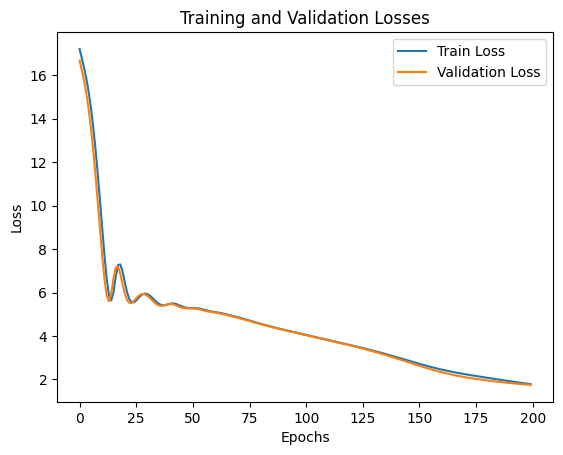

In [52]:
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()